# Unsupervised Learning Capstone - Creating NFL Quarterback Clusters 

## Intro

In this project, we will analyze a dataset containing data on the game stats of NFL quarterbacks. One goal of this project is to best describe the variation in the different types of quarterbacks that would help a fantasy football player choose who to draft and who to play or sit in terms of a quarterback.

One important stat in the NFL is the Quarterback passer rating. The NFL passer rating formula ranges on a scale from 0 to 158.3 based on completion percentage, yards per attempt, touchdowns per attempt, and interceptions per attempt. It's a quick and easy way to measure weekly quaterback performance and help a fantasy football fan decide who to draft or play for a game. We'll keep an eye out and see if this determines how the quarterbacks are segmented.

Each row in the dataset represents the quarterback stats for a single game. The dataset for this project can be found here: https://www.kaggle.com/speckledpingu/nfl-qb-stats/.

In [1]:
# Import necessary packages

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import scipy
import time
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn import metrics
import umap

# Data Exploration / Cleaning

In this section, we will begin exploring the data through visualizations and code to understand how each feature is related to the others. You will observe a statistical description of the dataset, consider the relevance of each feature, and select a few sample data points from the dataset which we will track through the course of this project.

In [2]:
# Import the data

df = pd.read_csv('/Users/colby/Desktop/Thinkful/QBStats_all.csv')

# How many rows / how many columns

df.shape

(13188, 14)

In [3]:
df.head()

,qb,att,cmp,yds,ypa,td,int,lg,sack,loss,rate,game_points,home_away,year
0,Boomer EsiasonB. Esiason,38,25,237.0,6.2,0,0,20,2.0,11.0,82.9,13,away,1996
1,Jim HarbaughJ. Harbaugh,25,16,196.0,7.8,2,1,35t,0.0,0.0,98.1,20,home,1996
2,Paul JustinP. Justin,8,5,53.0,6.6,0,0,30,1.0,11.0,81.8,20,home,1996
3,Jeff GeorgeJ. George,35,16,215.0,6.1,0,0,55,7.0,53.0,65.8,6,away,1996
4,Kerry CollinsK. Collins,31,17,198.0,6.4,2,0,30,4.0,12.0,95.9,29,home,1996


In [4]:
# Let's rename some of the column name to bring clarity

df = df.rename(columns={"att": "attempts", "cmp": "completions", "yds": "total_yards", "td": "touchdowns", 
                   "int": "interceptions", "lg": "longest_throw", "sack": "total_sacks", "rate": "qb_rating",
                       "loss": "loss_of_yards", "ypa": "yards_per_attempt", 'home_away': 'game'})

In [5]:
# Remove letters from 'longest_throw'
df['longest_throw'] = df['longest_throw'].str.extract('(\d+)', expand=False)

In [6]:
# Create new variable 'completion_rate' and round it to 2 decimal points

df["completion_rate"] = df['completions'] / df['attempts']
df["completion_rate"] = np.round(df["completion_rate"], decimals=2)
df["completion_rate"] = df["completion_rate"] * 100

In [7]:
# Drop rows that include NaN's

df = df.dropna()

In [8]:
# Convert 'longest_throw', 'interceptions' from object to int*

df['interceptions'] = df['interceptions'].astype(str).astype(int)
df['longest_throw'] = df['longest_throw'].astype(str).astype(int)

In [9]:
# Drop 'game_away' & 'qb' from dataframe

df.drop(['qb', 'year', 'game'], axis = 1, inplace = True)

In [10]:
df.describe()

,attempts,completions,total_yards,yards_per_attempt,touchdowns,interceptions,longest_throw,total_sacks,loss_of_yards,qb_rating,game_points,completion_rate
count,13074.000000,13074.000000,13074.000000,13074.000000,13074.000000,13074.000000,13074.000000,13074.000000,13074.000000,13074.000000,13074.000000,13074.000000
mean,27.095839,16.236576,187.755239,6.932523,1.127581,0.807863,33.611137,1.869130,12.015909,80.837915,21.371271,58.304803
std,13.422487,8.670919,104.648395,4.196369,1.119741,0.971456,18.114480,1.705797,11.997152,31.430212,10.653862,18.756481
min,1.000000,0.000000,-11.000000,-11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,11.000000,118.000000,5.300000,0.000000,0.000000,22.000000,0.000000,0.000000,59.200000,13.000000,51.000000
50%,29.000000,17.000000,198.000000,6.700000,1.000000,1.000000,31.000000,2.000000,9.000000,81.200000,21.000000,60.000000
75%,36.000000,22.000000,260.000000,8.100000,2.000000,1.000000,44.000000,3.000000,19.000000,102.200000,28.000000,68.000000
max,69.000000,43.000000,527.000000,81.000000,7.000000,7.000000,99.000000,12.000000,91.000000,158.300000,62.000000,100.000000


# Visualization

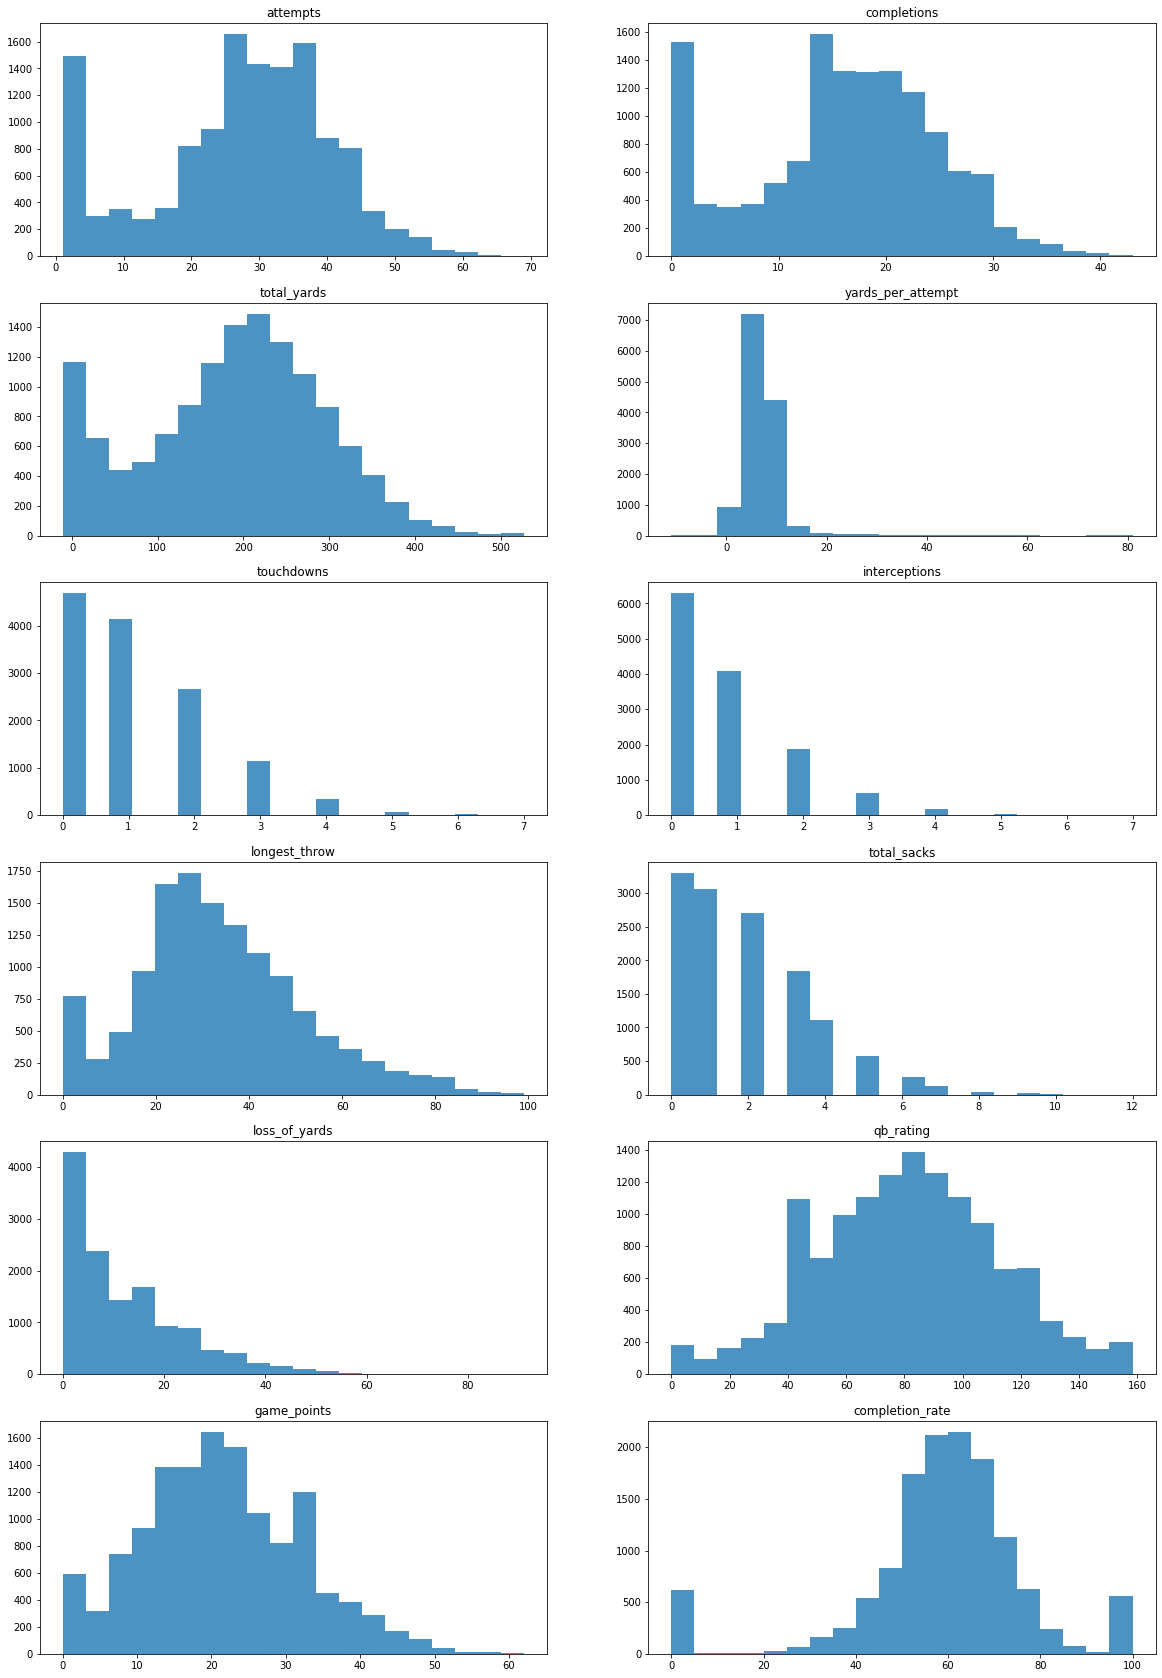

In [11]:
# Create a dictionary of columns.
col_dict = {'attempts':1,'completions':2,'total_yards':3,'yards_per_attempt':4,'touchdowns':5,
            'interceptions':6,'longest_throw':7,'total_sacks':8,'loss_of_yards':9,'qb_rating':10,'game_points':11,
            'completion_rate':12}

# View distribution in each variable using histograms.
plt.figure(figsize=(20,30))

for variable,i in col_dict.items():
                     plt.subplot(6,2,i)
                     plt.hist(df[variable], bins=20, alpha=.8)
                     plt.title(variable)

plt.show()

####  - Most of the data is not normally distributed; it is positively skewed.


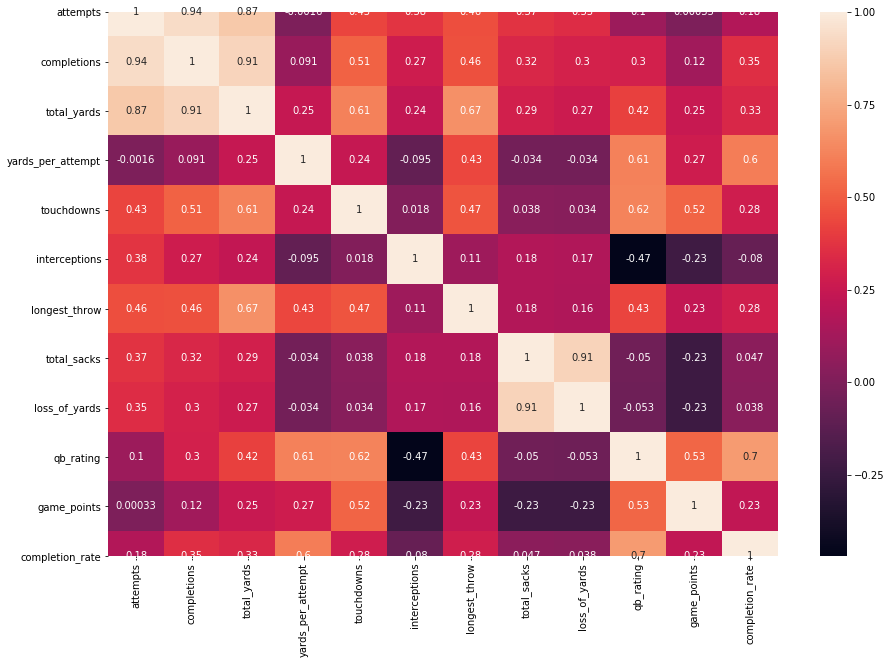

In [12]:
# Display a correlation matrix

plt.figure(figsize=(15,10))
sns.heatmap(df.corr(), annot=True)
plt.show()

####  - Strong correlation bewteen multiple features. 

    qb_rating - yards_per_attempt, touchdowns, interceptions, game_points, completion_rate
    completions - attemps
    attemps - total yards
    total_yards - longest_throw
    loss_of_yards - total_sacks

# Outlier Detection

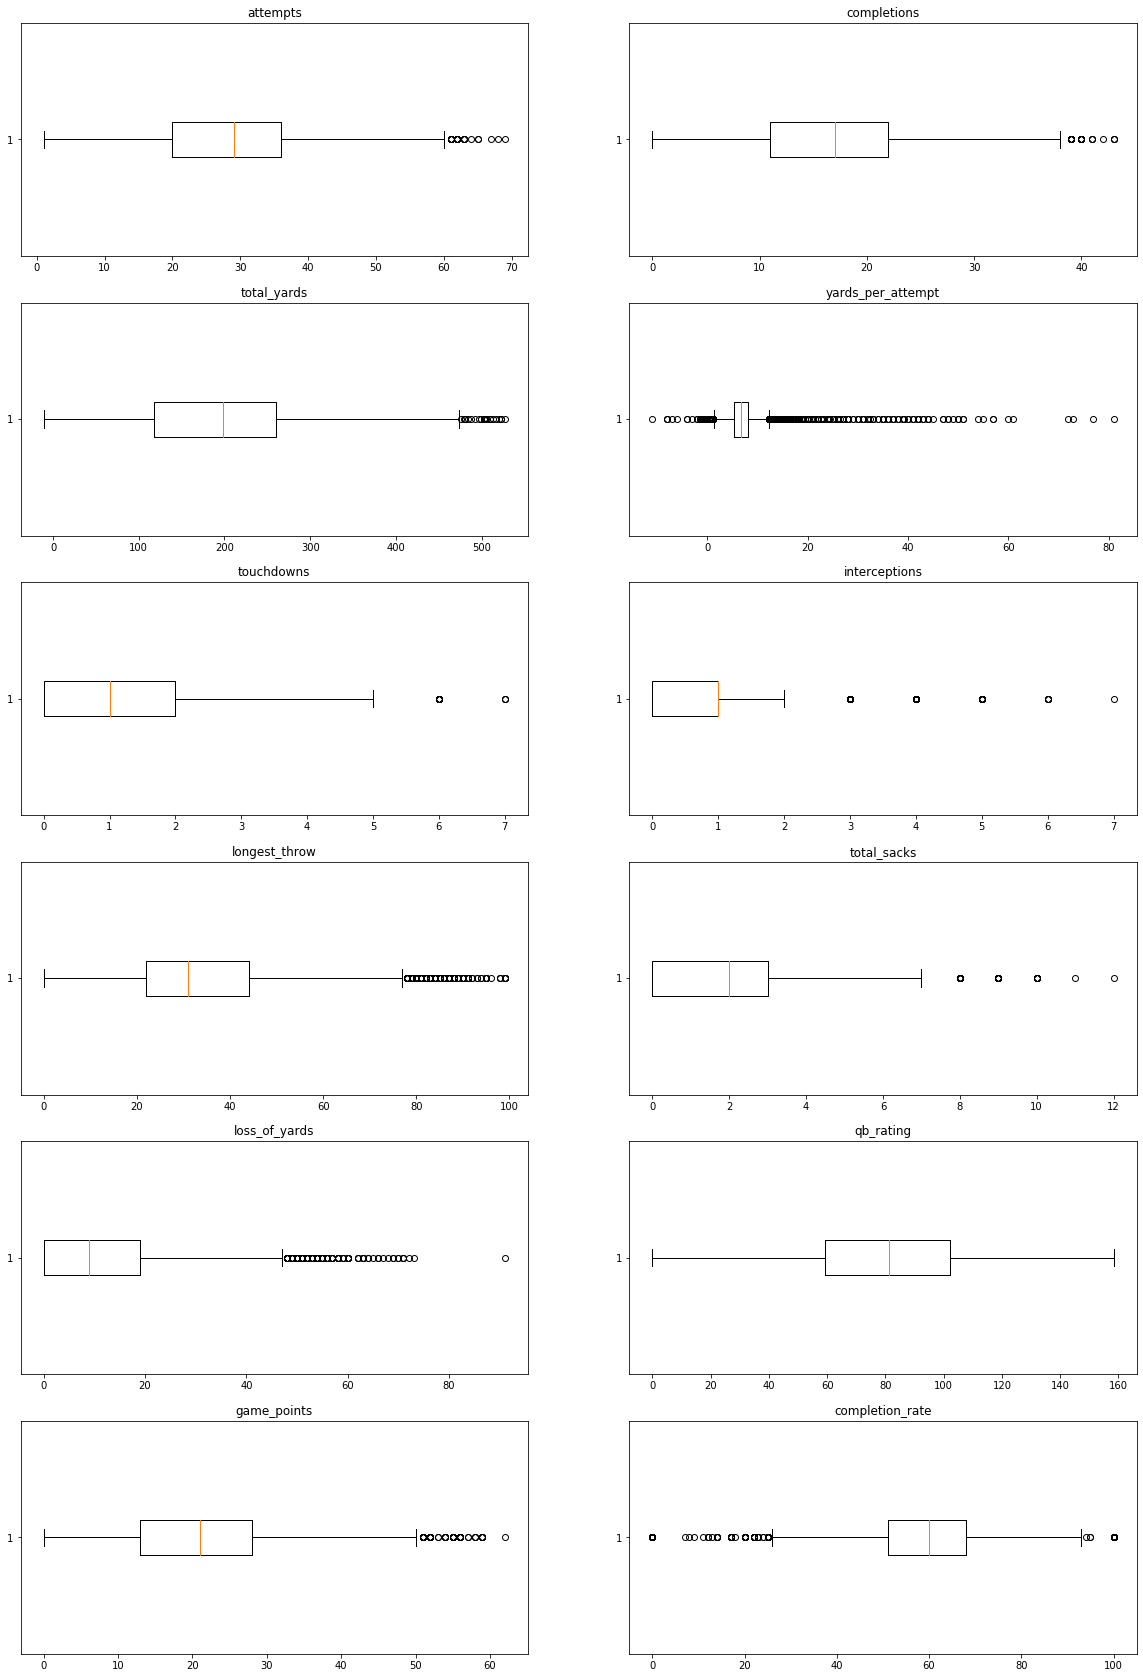

In [13]:
# Create a dictionary of columns.
col_dict = {'attempts':1,'completions':2,'total_yards':3,'yards_per_attempt':4,'touchdowns':5,
            'interceptions':6,'longest_throw':7,'total_sacks':8,'loss_of_yards':9,'qb_rating':10,'game_points':11,
            'completion_rate':12}

# Detect outliers in each variable using boxplots.
plt.figure(figsize=(20,30))

for variable,i in col_dict.items():
                     plt.subplot(6,2,i)
                     plt.boxplot(df[variable], vert=False)
                     plt.title(variable)

plt.show()

In [14]:
# Let's handle outliers

outliers = []

# For each feature find the data points with extreme high or low values
for feature in df.keys():
    
    # Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(df[feature],25)
    
    # Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(df[feature],75)
    
    # Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = 1.5 * (Q3-Q1)
    
    # Display the outliers
    print("Data points considered outliers for the feature '{}':".format(feature))
    display(df[~((df[feature] >= Q1 - step) & (df[feature] <= Q3 + step))])
    lista = df[~((df[feature] >= Q1 - step) & (df[feature] <= Q3 + step))].index.tolist()
    outliers.append(lista)

Data points considered outliers for the feature 'attempts':


,attempts,completions,total_yards,yards_per_attempt,touchdowns,interceptions,longest_throw,total_sacks,loss_of_yards,qb_rating,game_points,completion_rate
245,61,28,395.0,6.5,1,2,59,2.0,17.0,59.1,23,46.0
1742,63,42,418.0,6.6,2,1,30,0.0,0.0,89.3,32,67.0
3170,69,36,481.0,7.0,2,3,41,1.0,8.0,66.2,20,52.0
3219,63,33,326.0,5.2,1,3,46,2.0,11.0,52.7,10,52.0
3522,62,36,436.0,7.0,3,3,76,1.0,7.0,75.7,38,58.0
3718,68,35,411.0,6.0,2,1,49,2.0,8.0,73.8,26,51.0
3723,63,36,223.0,3.5,1,1,15,0.0,0.0,63.1,7,57.0
3856,64,43,403.0,6.3,1,2,34,5.0,34.0,76.5,30,67.0
4498,61,34,339.0,5.6,1,1,43,1.0,2.0,70.3,9,56.0
5876,62,40,442.0,7.1,2,3,31,1.0,8.0,76.1,24,65.0


Data points considered outliers for the feature 'completions':


,attempts,completions,total_yards,yards_per_attempt,touchdowns,interceptions,longest_throw,total_sacks,loss_of_yards,qb_rating,game_points,completion_rate
1742,63,42,418.0,6.6,2,1,30,0.0,0.0,89.3,32,67.0
2863,53,39,504.0,9.5,2,2,48,4.0,30.0,99.9,31,74.0
3525,56,40,399.0,7.1,0,2,35,2.0,9.0,76.4,24,71.0
3856,64,43,403.0,6.3,1,2,34,5.0,34.0,76.5,30,67.0
3870,54,39,410.0,7.6,4,1,38,4.0,11.0,110.9,41,72.0
5238,58,39,279.0,4.8,2,0,35,3.0,21.0,89.7,17,67.0
5651,60,40,492.0,8.2,4,1,32,3.0,26.0,107.1,35,67.0
5876,62,40,442.0,7.1,2,3,31,1.0,8.0,76.1,24,65.0
6771,54,39,323.0,6.0,1,1,22,4.0,14.0,85.6,11,72.0
7738,48,39,421.0,8.8,1,0,74,1.0,7.0,110.2,32,81.0


Data points considered outliers for the feature 'total_yards':


,attempts,completions,total_yards,yards_per_attempt,touchdowns,interceptions,longest_throw,total_sacks,loss_of_yards,qb_rating,game_points,completion_rate
351,59,35,522.0,8.8,3,4,64,2.0,15.0,77.1,37,59.0
2863,53,39,504.0,9.5,2,2,48,4.0,30.0,99.9,31,74.0
3170,69,36,481.0,7.0,2,3,41,1.0,8.0,66.2,20,52.0
5374,55,31,499.0,9.1,4,3,80,0.0,0.0,88.4,28,56.0
5651,60,40,492.0,8.2,4,1,32,3.0,26.0,107.1,35,67.0
6726,52,37,510.0,9.8,2,3,72,2.0,6.0,91.0,16,71.0
7425,48,34,484.0,10.1,2,2,62,4.0,30.0,99.7,31,71.0
8833,46,29,503.0,10.9,3,0,60,5.0,31.0,121.9,37,63.0
9003,52,38,497.0,9.6,3,1,50,5.0,29.0,114.0,30,73.0
9043,57,37,476.0,8.4,1,1,61,1.0,4.0,89.5,13,65.0


Data points considered outliers for the feature 'yards_per_attempt':


,attempts,completions,total_yards,yards_per_attempt,touchdowns,interceptions,longest_throw,total_sacks,loss_of_yards,qb_rating,game_points,completion_rate
8,1,1,-8.0,-8.0,0,0,8,0.0,0.0,79.2,13,100.0
19,2,0,0.0,0.0,0,0,0,0.0,0.0,39.6,9,0.0
22,1,1,24.0,24.0,0,0,24,0.0,0.0,118.8,34,100.0
28,2,0,0.0,0.0,0,0,0,0.0,0.0,39.6,27,0.0
32,1,0,0.0,0.0,0,0,0,0.0,0.0,39.6,31,0.0
40,1,1,33.0,33.0,1,0,33,0.0,0.0,158.3,22,100.0
41,1,1,47.0,47.0,0,0,47,0.0,0.0,118.8,22,100.0
55,1,0,0.0,0.0,0,0,0,0.0,0.0,39.6,10,0.0
66,1,0,0.0,0.0,0,1,0,0.0,0.0,0.0,27,0.0
85,1,0,0.0,0.0,0,0,0,0.0,0.0,39.6,39,0.0


Data points considered outliers for the feature 'touchdowns':


,attempts,completions,total_yards,yards_per_attempt,touchdowns,interceptions,longest_throw,total_sacks,loss_of_yards,qb_rating,game_points,completion_rate
4586,25,20,314.0,12.6,6,0,79,1.0,9.0,158.3,55,80.0
5496,28,23,236.0,8.4,6,0,25,0.0,0.0,141.4,41,82.0
7043,50,33,401.0,8.0,6,2,32,1.0,7.0,113.4,45,66.0
7225,25,21,354.0,14.2,6,0,50,1.0,10.0,158.3,49,84.0
7768,34,24,289.0,8.5,6,1,40,2.0,5.0,123.7,56,71.0
8280,34,26,358.0,10.5,6,1,58,0.0,0.0,137.0,45,76.0
8485,34,29,380.0,11.2,6,0,48,2.0,6.0,152.8,59,85.0
10140,44,31,480.0,10.9,6,1,80,3.0,11.0,136.4,45,70.0
10381,37,24,338.0,9.1,6,0,48,2.0,10.0,133.8,42,65.0
10782,42,27,462.0,11.0,7,0,78,3.0,17.0,141.1,49,64.0


Data points considered outliers for the feature 'interceptions':


,attempts,completions,total_yards,yards_per_attempt,touchdowns,interceptions,longest_throw,total_sacks,loss_of_yards,qb_rating,game_points,completion_rate
7,41,20,260.0,6.3,1,4,29,3.0,8.0,37.7,13,49.0
23,30,13,123.0,4.1,0,4,16,1.0,6.0,15.7,3,43.0
56,27,14,173.0,6.4,1,3,63,2.0,19.0,44.8,17,52.0
82,25,10,142.0,5.7,0,3,62,2.0,12.0,19.5,13,40.0
91,40,25,217.0,5.4,2,3,28,1.0,9.0,62.2,13,62.0
97,40,18,199.0,5.0,1,3,24,1.0,8.0,37.4,14,45.0
98,39,21,296.0,7.6,0,3,47,1.0,9.0,46.5,15,54.0
100,44,25,325.0,7.4,3,3,78,2.0,21.0,74.5,27,57.0
112,31,17,201.0,6.5,1,4,35,4.0,19.0,46.0,10,55.0
115,31,15,116.0,3.7,0,4,18,2.0,17.0,18.4,6,48.0


Data points considered outliers for the feature 'longest_throw':


,attempts,completions,total_yards,yards_per_attempt,touchdowns,interceptions,longest_throw,total_sacks,loss_of_yards,qb_rating,game_points,completion_rate
100,44,25,325.0,7.4,3,3,78,2.0,21.0,74.5,27,57.0
122,27,14,198.0,7.3,2,1,80,7.0,41.0,85.1,21,52.0
200,32,18,299.0,9.3,3,1,80,0.0,0.0,106.1,22,56.0
343,41,30,419.0,10.2,3,2,84,1.0,10.0,109.7,42,73.0
426,33,20,275.0,8.3,1,2,82,1.0,12.0,72.2,16,61.0
474,17,9,204.0,12.0,1,2,95,3.0,21.0,76.2,10,53.0
487,17,6,142.0,8.4,2,0,83,0.0,0.0,105.5,35,35.0
592,32,23,307.0,9.6,3,2,86,4.0,50.0,107.2,21,72.0
650,28,17,246.0,8.8,0,0,78,2.0,14.0,89.3,19,61.0
816,23,9,195.0,8.5,1,1,89,2.0,10.0,66.4,20,39.0


Data points considered outliers for the feature 'total_sacks':


,attempts,completions,total_yards,yards_per_attempt,touchdowns,interceptions,longest_throw,total_sacks,loss_of_yards,qb_rating,game_points,completion_rate
29,13,7,50.0,3.8,0,1,15,8.0,53.0,30.9,6,54.0
220,30,23,229.0,7.6,1,1,19,10.0,71.0,95.0,10,77.0
241,25,11,105.0,4.2,0,1,21,8.0,42.0,39.6,10,44.0
676,37,16,218.0,5.9,1,2,39,8.0,55.0,49.2,22,43.0
721,17,11,77.0,4.5,0,0,14,8.0,54.0,74.9,3,65.0
971,22,13,148.0,6.7,0,0,29,8.0,40.0,79.4,6,59.0
1004,33,22,388.0,11.8,1,2,70,8.0,38.0,91.5,10,67.0
1025,38,26,276.0,7.3,0,0,26,9.0,66.0,89.4,10,68.0
1106,26,15,270.0,10.4,2,0,44,10.0,53.0,119.1,20,58.0
1148,32,14,151.0,4.7,2,1,18,8.0,58.0,66.0,14,44.0


Data points considered outliers for the feature 'loss_of_yards':


,attempts,completions,total_yards,yards_per_attempt,touchdowns,interceptions,longest_throw,total_sacks,loss_of_yards,qb_rating,game_points,completion_rate
3,35,16,215.0,6.1,0,0,55,7.0,53.0,65.8,6,46.0
29,13,7,50.0,3.8,0,1,15,8.0,53.0,30.9,6,54.0
36,41,24,313.0,7.6,1,1,60,7.0,56.0,80.6,23,59.0
220,30,23,229.0,7.6,1,1,19,10.0,71.0,95.0,10,77.0
226,32,21,247.0,7.7,0,3,49,7.0,56.0,49.9,7,66.0
404,47,28,215.0,4.6,0,2,17,6.0,54.0,53.1,3,60.0
592,32,23,307.0,9.6,3,2,86,4.0,50.0,107.2,21,72.0
627,26,12,131.0,5.0,1,0,44,4.0,52.0,74.4,7,46.0
676,37,16,218.0,5.9,1,2,39,8.0,55.0,49.2,22,43.0
712,25,13,145.0,5.8,0,0,59,7.0,52.0,69.6,7,52.0


Data points considered outliers for the feature 'qb_rating':


,attempts,completions,total_yards,yards_per_attempt,touchdowns,interceptions,longest_throw,total_sacks,loss_of_yards,qb_rating,game_points,completion_rate


Data points considered outliers for the feature 'game_points':


,attempts,completions,total_yards,yards_per_attempt,touchdowns,interceptions,longest_throw,total_sacks,loss_of_yards,qb_rating,game_points,completion_rate
355,24,15,188.0,7.8,2,0,23,1.0,3.0,114.6,59,62.0
1084,31,20,282.0,9.1,2,1,50,2.0,8.0,101.8,55,65.0
1404,20,12,189.0,9.4,2,2,38,1.0,22.0,85.2,51,60.0
1405,2,1,10.0,5.0,0,0,10,1.0,6.0,64.6,51,50.0
1406,1,1,22.0,22.0,0,0,22,0.0,0.0,118.8,51,100.0
2710,30,24,390.0,13.0,4,0,53,2.0,14.0,158.3,57,80.0
2711,4,3,75.0,18.8,1,0,48,0.0,0.0,156.2,57,75.0
2823,30,18,266.0,8.9,2,0,30,2.0,13.0,111.2,54,60.0
2824,3,3,78.0,26.0,1,0,39,0.0,0.0,158.3,54,100.0
2825,1,1,31.0,31.0,0,0,31,0.0,0.0,118.8,54,100.0


Data points considered outliers for the feature 'completion_rate':


,attempts,completions,total_yards,yards_per_attempt,touchdowns,interceptions,longest_throw,total_sacks,loss_of_yards,qb_rating,game_points,completion_rate
8,1,1,-8.0,-8.0,0,0,8,0.0,0.0,79.2,13,100.0
19,2,0,0.0,0.0,0,0,0,0.0,0.0,39.6,9,0.0
22,1,1,24.0,24.0,0,0,24,0.0,0.0,118.8,34,100.0
28,2,0,0.0,0.0,0,0,0,0.0,0.0,39.6,27,0.0
32,1,0,0.0,0.0,0,0,0,0.0,0.0,39.6,31,0.0
35,1,1,7.0,7.0,0,0,7,0.0,0.0,95.8,29,100.0
40,1,1,33.0,33.0,1,0,33,0.0,0.0,158.3,22,100.0
41,1,1,47.0,47.0,0,0,47,0.0,0.0,118.8,22,100.0
55,1,0,0.0,0.0,0,0,0,0.0,0.0,39.6,10,0.0
64,3,3,24.0,8.0,1,0,12,0.0,0.0,139.6,14,100.0


In [15]:
# Find datapoint that are present in more than one feature so they can be removed

seen = {}
dupes = []

for lista in outliers:
    for index in lista:
        if index not in seen:
            seen[index] = 1
        else:
            if seen[index] == 1:
                dupes.append(index)
            seen[index] += 1
dupes = sorted(dupes)
print(len(dupes))

1127


There are 1127 datapoints considered outliers that are present in more than one feature.

K-Means is heavily influenced by the presence of outliers as they increase significantly the loss function that the algorithm tries to minimize. This loss function is the squared sum of the distances of each datapoint to the centroid, so, if the outlier is far enough, the centroid will be incorrectly situated. Because of this, the outliers will be removed.

In [16]:
# Create new df after handling outliers

df = df.drop(dupes, axis=0).reset_index(drop=True)

# How many rows / how many columns after handling outliers:

df.shape

(11947, 12)

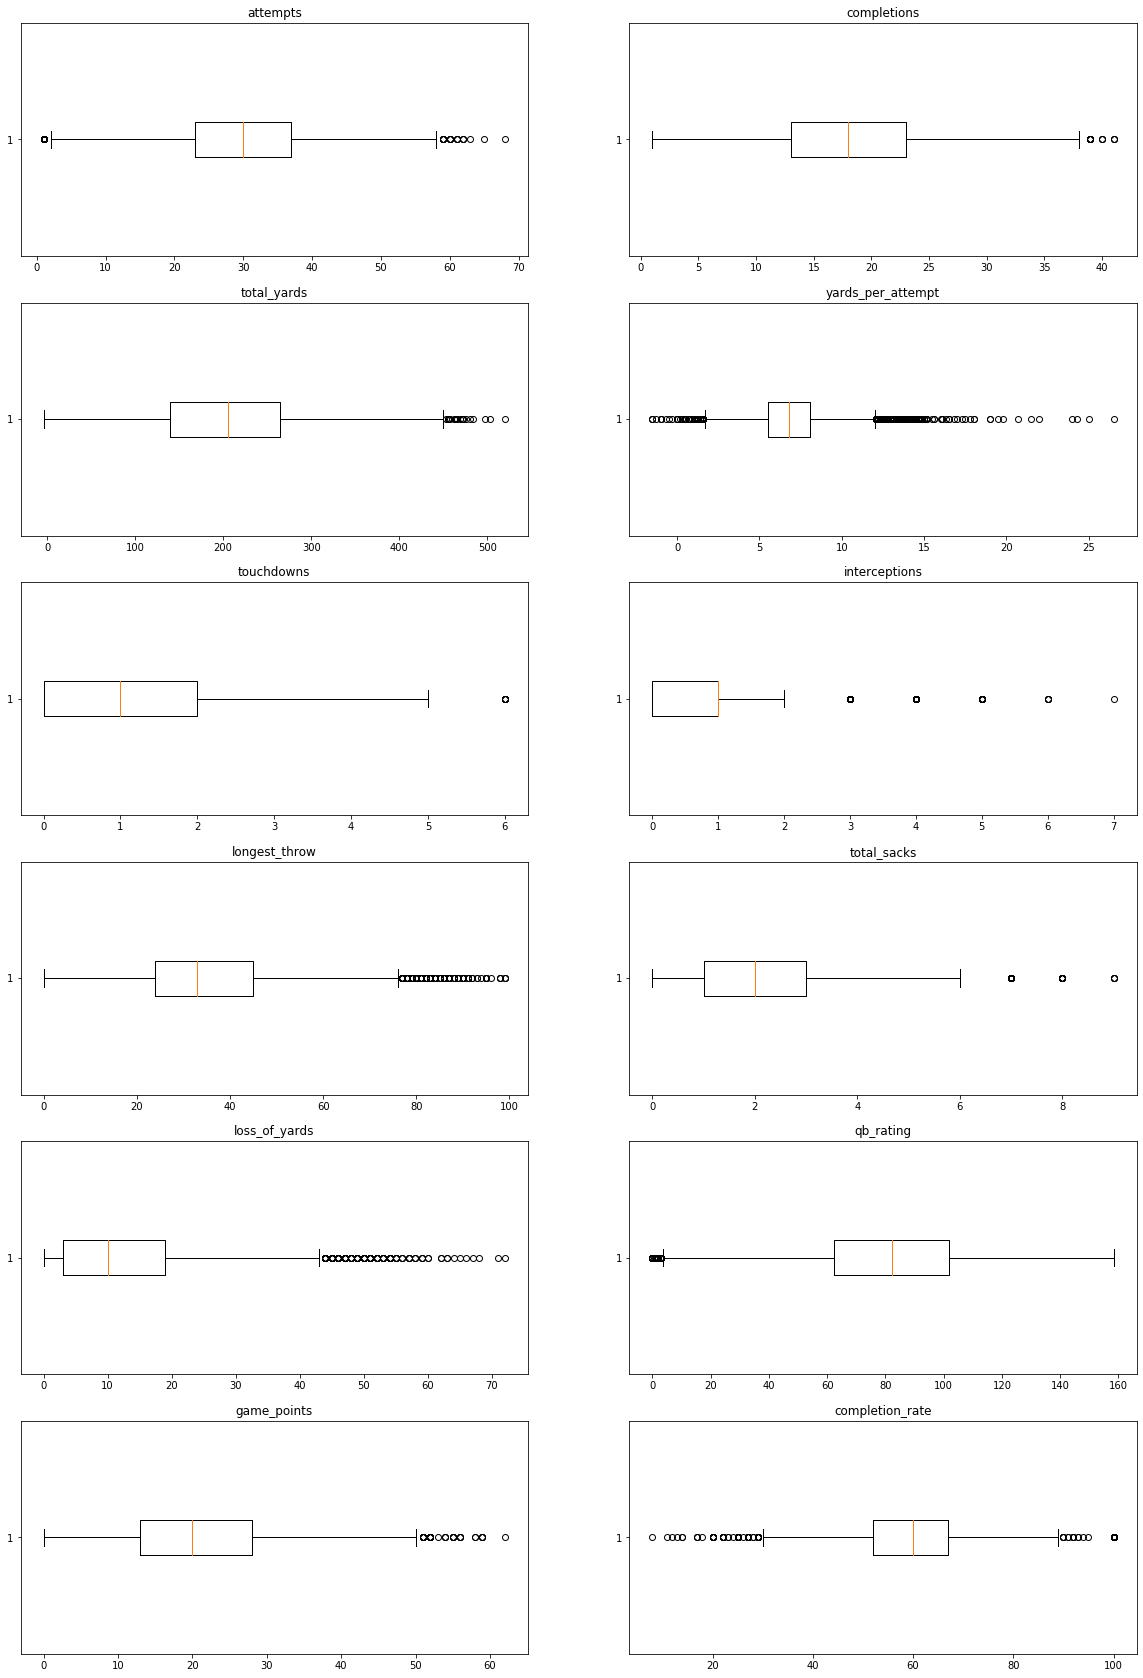

In [17]:
# View each variable using boxplots after handling outliers.

# Create a dictionary of columns.
col_dict = {'attempts':1,'completions':2,'total_yards':3,'yards_per_attempt':4,'touchdowns':5,
            'interceptions':6,'longest_throw':7,'total_sacks':8,'loss_of_yards':9,'qb_rating':10,'game_points':11,
            'completion_rate':12}

plt.figure(figsize=(20,30))

for variable,i in col_dict.items():
                     plt.subplot(6,2,i)
                     plt.boxplot(df[variable], vert=False)
                     plt.title(variable)

plt.show()

After handling outlier, you can see the biggest change in the 'yards_per_attempt', 'loss_of_yards', and 'total_yards' variables.

# Selecting Samples

To get a better understanding of the quarterbacks and how their data will transform through the analysis, let's select a few sample data points and explore them in more detail. Later, we'll observe how these samples are clustered.

In [18]:
# Select three indices of your choice you wish to sample from the dataset
indices = [211,7000,973]

# Create a DataFrame of the chosen samples
samples = pd.DataFrame(df.loc[indices], columns = df.keys()).reset_index(drop = True)
print("Chosen samples of dataset:")
display(samples)

Chosen samples of dataset:


,attempts,completions,total_yards,yards_per_attempt,touchdowns,interceptions,longest_throw,total_sacks,loss_of_yards,qb_rating,game_points,completion_rate
0,38,27,295.0,7.8,4,0,62,0.0,0.0,128.7,37,71.0
1,32,17,236.0,7.4,0,1,53,2.0,23.0,64.1,14,53.0
2,19,10,101.0,5.3,0,3,24,6.0,32.0,28.5,3,53.0


In [19]:
df.describe()

,attempts,completions,total_yards,yards_per_attempt,touchdowns,interceptions,longest_throw,total_sacks,loss_of_yards,qb_rating,game_points,completion_rate
count,11947.000000,11947.000000,11947.000000,11947.000000,11947.000000,11947.000000,11947.000000,11947.000000,11947.000000,11947.000000,11947.000000,11947.000000
mean,29.046120,17.426048,200.682431,6.880079,1.196116,0.852432,35.373064,1.979576,12.702687,82.074312,21.184398,60.280405
std,11.664931,7.680859,94.146412,2.172618,1.105497,0.973310,16.513509,1.631942,11.574745,29.113624,10.425530,12.359191
min,1.000000,1.000000,-4.000000,-1.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000
25%,23.000000,13.000000,140.000000,5.500000,0.000000,0.000000,24.000000,1.000000,3.000000,62.400000,13.000000,52.000000
50%,30.000000,18.000000,206.000000,6.800000,1.000000,1.000000,33.000000,2.000000,10.000000,82.200000,20.000000,60.000000
75%,37.000000,23.000000,265.000000,8.100000,2.000000,1.000000,45.000000,3.000000,19.000000,101.800000,28.000000,67.000000
max,68.000000,41.000000,520.000000,26.500000,6.000000,7.000000,99.000000,9.000000,72.000000,158.300000,62.000000,100.000000


Considering the statistical description of the dataset above for our quarterbacks, we'll attmept to make a prediction on what kind of quarterback could each of the three samples chosen represent?

The mean values are as follows:

    - attempts: 29
    - completions: 17 
    - total_yards: 200 
    - yards_per_attempt: 7
    - touchdowns: 1
    - interceptions: 1
    - longest_throw: 35 
    - total_sacks: 2
    - loss_of_yards: 13 
    - qb_rating: %82 
    - game_points: 21 
    - completion_rate: %60

Knowing this, how do our samples compare?

1) Index 21: Strong performer:

    - High QB rating.

    - 4 passing touchdowns.

    - 0 interceptions.
    
    - Longest Throw of 62 yards.
    
    - 0 sacks.

2) Index 7000: Average performer:

    - Near average QB rating.

    - 1 interception.

    - 2 sacks.

3) Index 973: Poor performer:

    - Below average QB rating.

    - 0 passing touchdowns.

    - 3 interceptions.
    
    - 6 sacks.


# Feature Scaling

We'll normalize the data by applying the natural logarithm.

In [20]:
# Scale the data using the natural logarithm
log_data = np.log(df)

# Scale the sample data using the natural logarithm
log_samples = np.log(samples)

log_data = log_data.replace(-np.Inf, 0)
log_samples = log_samples.replace(-np.Inf, 0)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


In [21]:
# Verifying null-values.
log_data.isnull().sum()

attempts              0
completions           0
total_yards          10
yards_per_attempt    10
touchdowns            0
interceptions         0
longest_throw         0
total_sacks           0
loss_of_yards         0
qb_rating             0
game_points           0
completion_rate       0
dtype: int64

In [22]:
# Drop rows that include NaN's

log_data = log_data.dropna()

In [23]:
log_data.head()

,attempts,completions,total_yards,yards_per_attempt,touchdowns,interceptions,longest_throw,total_sacks,loss_of_yards,qb_rating,game_points,completion_rate
0,3.637586,3.218876,5.468060,1.824549,0.000000,0.0,2.995732,0.693147,2.397895,4.417635,2.564949,4.189655
1,3.218876,2.772589,5.278115,2.054124,0.693147,0.0,3.555348,0.000000,0.000000,4.585987,2.995732,4.158883
2,2.079442,1.609438,3.970292,1.887070,0.000000,0.0,3.401197,0.000000,2.397895,4.404277,2.995732,4.127134
3,3.555348,2.772589,5.370638,1.808289,0.000000,0.0,4.007333,1.945910,3.970292,4.186620,1.791759,3.828641
4,3.433987,2.833213,5.288267,1.856298,0.693147,0.0,3.401197,1.386294,2.484907,4.563306,3.367296,4.007333


In [25]:
# Display the log-transformed sample data
display(log_samples)

,attempts,completions,total_yards,yards_per_attempt,touchdowns,interceptions,longest_throw,total_sacks,loss_of_yards,qb_rating,game_points,completion_rate
0,3.637586,3.295837,5.686975,2.054124,1.386294,0.000000,4.127134,0.000000,0.000000,4.857484,3.610918,4.262680
1,3.465736,2.833213,5.463832,2.001480,0.000000,0.000000,3.970292,0.693147,3.135494,4.160444,2.639057,3.970292
2,2.944439,2.302585,4.615121,1.667707,0.000000,1.098612,3.178054,1.791759,3.465736,3.349904,1.098612,3.970292


In [26]:
log_samples.shape

(3, 12)

# Dimensionality Reduction : PCA

We'll apply PCA to log_data and log_samples to discover which dimensions about the data best maximize the variance of features involved.

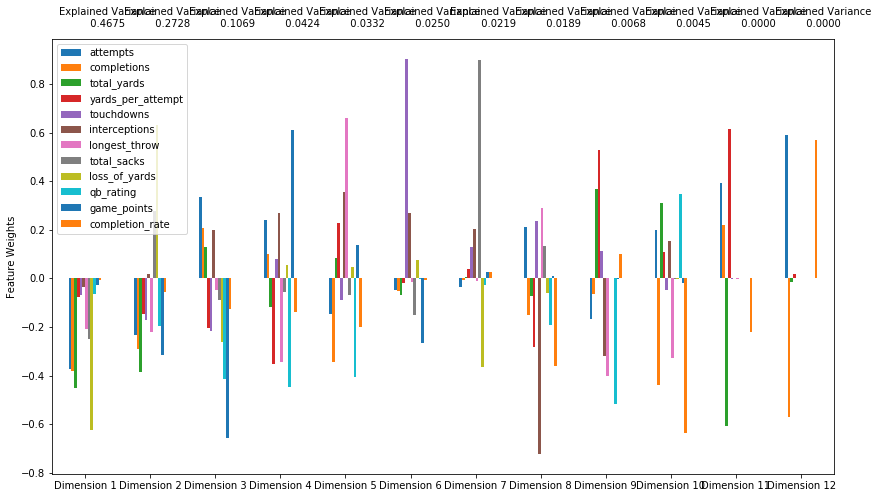

In [27]:
import visuals2 as vs

# TODO: Apply PCA by fitting the good data with the same number of dimensions as features
from sklearn.decomposition import PCA
pca = PCA(n_components=log_data.shape[1])
pca = pca.fit(log_data)

# TODO: Transform log_samples using the PCA fit above
pca_samples = pca.transform(log_samples)

# Generate PCA results plot
pca_results = vs.pca_results(log_data, pca)

The first two Principal Components explains ~74% of the total variance. We'll move forward with that.

In [28]:
# Apply PCA by fitting the good data with only two dimensions
pca = PCA(n_components=2).fit(log_data)

# Transform the good data using the PCA fit above
reduced_data = pca.transform(log_data)

# Transform log_samples using the PCA fit above
pca_samples = pca.transform(log_samples)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

In [29]:
# Display sample log-data after applying PCA transformation in two dimensions
display(pd.DataFrame(np.round(pca_samples, 4), columns = ['Dimension 1', 'Dimension 2']))

,Dimension 1,Dimension 2
0,0.4482,-2.6360
1,-1.1320,0.5291
2,-0.5906,2.5293


# Clustering

In this section, we will choose to use either a K-Means clustering algorithm or a Gaussian Mixture Model clustering algorithm to identify the various customer segments hidden in the data. We will then recover specific data points from the clusters to understand their significance by transforming them back into their original dimension and scale.

1) The main advantages of using K-Means as a cluster algorithm are:

- It is easy to implement.

- With large number of variables, if (K is small), it may be computationally faster than hierarchichal clustering.

- Consistent and scale-invariant.

2) The main advantages of using Gaussian Mixture Models as a cluster algorithm are:

- It is much more flexible in terms of cluster covariance. Which means that each cluster can have unconstrained covariance structure. In other words, whereas K-means assumes that every cluster have spherical estructure, GMM allows eliptical.

- Points can belong to different clusters, with different level of memebership. This level of membership is the probability of each point to belong to each cluster.


# Creating the clusters

### Let's start with KMeans

In [30]:
scores = {}
for i in range(2,7):
    
    print('Number of clusters: ' + str(i))
        
    # Apply your clustering algorithm of choice to the reduced data 
    clusterer = KMeans(n_clusters = i, random_state=123)
    clusterer.fit(reduced_data)

    # Predict the cluster for each data point
    preds = clusterer.predict(reduced_data)

    # cluster centers
    centers = clusterer.cluster_centers_ 
    print('Cluster Center: ' + str(centers))

    # Predict the cluster for each transformed sample data point
    sample_preds = clusterer.predict(pca_samples)
    print('Sample predictions: ' + str(sample_preds))

    # Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_data, preds)
    scores[i] = score
    print('Silhouette score is: ' + str(score), '\n')
    
print('Scores: ' + str(scores))

Number of clusters: 2
Cluster Center: [[ 1.85968852 -0.67506659]
 [-0.77772408  0.2823137 ]]
Sample predictions: [0 1 1]
Silhouette score is: 0.49439128149659706 

Number of clusters: 3
Cluster Center: [[-0.83604409  0.4178115 ]
 [ 0.71762624 -1.41361077]
 [ 3.63273952  1.28832204]]
Sample predictions: [1 0 0]
Silhouette score is: 0.47798960105131016 

Number of clusters: 4
Cluster Center: [[-0.95987909  0.94163651]
 [ 1.04882894 -1.63425161]
 [-0.54473982 -0.34391655]
 [ 3.71211123  1.29179523]]
Sample predictions: [1 0 0]
Silhouette score is: 0.3807303798712084 

Number of clusters: 5
Cluster Center: [[-1.28751315  0.65766916]
 [ 1.07533681 -1.64595714]
 [-0.51552493 -0.46599204]
 [ 4.05390278  1.25200398]
 [ 0.36776393  1.27177418]]
Sample predictions: [1 0 4]
Silhouette score is: 0.40404374296497064 

Number of clusters: 6
Cluster Center: [[-1.33208709  0.55556277]
 [ 2.45129034 -0.03153836]
 [-0.45014574 -0.45487083]
 [ 4.59730977  1.77846041]
 [ 0.05636715  1.38924965]
 [ 0.89611

### Now let's see if we can get a better silhouette score with GaussianMixture

In [31]:
scores = {}
for i in range(2,7):
    
    print('Number of clusters: ' + str(i))
        
    # Apply your clustering algorithm of choice to the reduced data 
    clusterer = GaussianMixture(random_state=123, n_components=i)
    clusterer.fit(reduced_data)

    # Predict the cluster for each data point
    preds = clusterer.predict(reduced_data)

    # Find the cluster centers
    centers = clusterer.means_
    print('Cluster Center: ' + str(centers))

    # Predict the cluster for each transformed sample data point
    sample_preds = clusterer.predict(pca_samples)
    print('Sample predictions: ' + str(sample_preds))

    # Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_data, preds)
    scores[i] = score
    print('Silhouette score is: ' + str(score), '\n')
    
print('Scores: ' + str(scores))

Number of clusters: 2
Cluster Center: [[-0.7364128   0.27785707]
 [ 1.87014633 -0.70562784]]
Sample predictions: [1 0 0]
Silhouette score is: 0.5044949543526048 

Number of clusters: 3
Cluster Center: [[-0.77821667  0.15597866]
 [ 2.35494714  1.11034755]
 [ 1.09497884 -1.77608593]]
Sample predictions: [2 0 0]
Silhouette score is: 0.4803197441077763 

Number of clusters: 4
Cluster Center: [[-1.03769567  0.76135726]
 [ 1.09710825 -1.77724733]
 [-0.53561869 -0.31118745]
 [ 2.61704473  1.07118441]]
Sample predictions: [1 0 0]
Silhouette score is: 0.3671236800385996 

Number of clusters: 5
Cluster Center: [[-1.19330725  0.59194213]
 [ 0.98692452 -1.89054952]
 [-0.41323182 -0.3602049 ]
 [ 3.47204013  0.32290455]
 [ 0.57894413  1.20271019]]
Sample predictions: [1 0 4]
Silhouette score is: 0.37663191548108327 

Number of clusters: 6
Cluster Center: [[-1.2318252   0.51450297]
 [ 3.10436211  0.01115017]
 [-0.40869886 -0.40754341]
 [ 3.41331228  2.20058228]
 [ 0.11720622  1.04607117]
 [ 0.9555030

### GaussianMixture got a slightly higher silhouette score with 2 clusters, so let's move forward with that

In [32]:
# Apply your clustering algorithm of choice to the reduced data 
clusterer = GaussianMixture(random_state=123, n_components=2)
clusterer.fit(reduced_data)

# Predict the cluster for each data point
preds = clusterer.predict(reduced_data)

# Find the cluster centers
centers = clusterer.means_
print('Cluster Center: ' + str(centers))

# Predict the cluster for each transformed sample data point
sample_preds = clusterer.predict(pca_samples)
print('Sample predictions: ' + str(sample_preds))

# Calculate the mean silhouette coefficient for the number of clusters chosen
score = silhouette_score(reduced_data, preds)
scores[i] = score
print('Silhouette score is: ' + str(score), '\n')

Cluster Center: [[-0.7364128   0.27785707]
 [ 1.87014633 -0.70562784]]
Sample predictions: [1 0 0]
Silhouette score is: 0.5044949543526048 



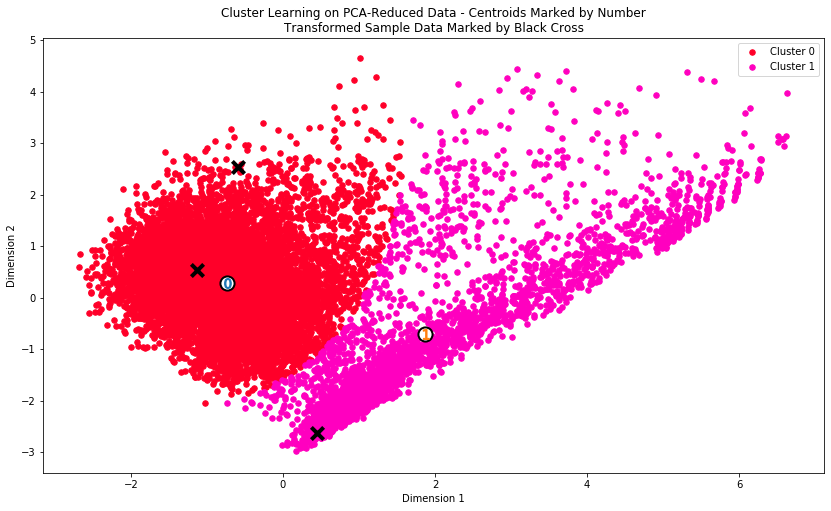

In [33]:
# Display the results of the clustering from implementation
vs.cluster_results(reduced_data, preds, centers, pca_samples)

## Data Recovery

Each cluster present in the visualization above has a central point. These centers (or means) are not specifically data points from the data, but rather the averages of all the data points predicted in the respective clusters. For the problem of creating customer segments, a cluster's center point corresponds to the average customer of that segment. Since the data is currently reduced in dimension and scaled by a logarithm, we can recover the representative customer spending from these data points by applying the inverse transformations.

In [34]:
# Inverse transform the centers
log_centers = pca.inverse_transform(centers)

# Exponentiate the centers
true_centers = np.exp(log_centers)

# Display the true centers
segments = ['Cluster {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = df.keys())
true_centers.index = segments
display(true_centers)

,attempts,completions,total_yards,yards_per_attempt,touchdowns,interceptions,longest_throw,total_sacks,loss_of_yards,qb_rating,game_points,completion_rate
Cluster 0,31.0,18.0,203.0,7.0,1.0,1.0,34.0,2.0,14.0,75.0,17.0,58.0
Cluster 1,15.0,9.0,92.0,6.0,1.0,1.0,25.0,1.0,1.0,77.0,21.0,60.0


### Observations

   - Cluster 0 may represent a stronger quarterback performance due to more total_yards. There's also more attempts made and greater longest_throw which could indicate more experience and courage. You can also noticed more sacks and loss of yards.

   - Cluster 1 may represent a weaker quarterback performance due to lesser total_yards and less attemps. that could indicate less experience or grit. You can see a smaller longest_throw.

In [35]:
df.describe()

,attempts,completions,total_yards,yards_per_attempt,touchdowns,interceptions,longest_throw,total_sacks,loss_of_yards,qb_rating,game_points,completion_rate
count,11947.000000,11947.000000,11947.000000,11947.000000,11947.000000,11947.000000,11947.000000,11947.000000,11947.000000,11947.000000,11947.000000,11947.000000
mean,29.046120,17.426048,200.682431,6.880079,1.196116,0.852432,35.373064,1.979576,12.702687,82.074312,21.184398,60.280405
std,11.664931,7.680859,94.146412,2.172618,1.105497,0.973310,16.513509,1.631942,11.574745,29.113624,10.425530,12.359191
min,1.000000,1.000000,-4.000000,-1.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000
25%,23.000000,13.000000,140.000000,5.500000,0.000000,0.000000,24.000000,1.000000,3.000000,62.400000,13.000000,52.000000
50%,30.000000,18.000000,206.000000,6.800000,1.000000,1.000000,33.000000,2.000000,10.000000,82.200000,20.000000,60.000000
75%,37.000000,23.000000,265.000000,8.100000,2.000000,1.000000,45.000000,3.000000,19.000000,101.800000,28.000000,67.000000
max,68.000000,41.000000,520.000000,26.500000,6.000000,7.000000,99.000000,9.000000,72.000000,158.300000,62.000000,100.000000


In [36]:
display(samples)

,attempts,completions,total_yards,yards_per_attempt,touchdowns,interceptions,longest_throw,total_sacks,loss_of_yards,qb_rating,game_points,completion_rate
0,38,27,295.0,7.8,4,0,62,0.0,0.0,128.7,37,71.0
1,32,17,236.0,7.4,0,1,53,2.0,23.0,64.1,14,53.0
2,19,10,101.0,5.3,0,3,24,6.0,32.0,28.5,3,53.0


In [37]:
# Display the predictions
for i, pred in enumerate(sample_preds):
    print("Sample point", i, "predicted to be in Cluster", pred)

Sample point 0 predicted to be in Cluster 1
Sample point 1 predicted to be in Cluster 0
Sample point 2 predicted to be in Cluster 0


   - Sample point 0: Weaker performance and the original guess was a strong performer.

   - Sample point 1: The orginal discription for this performance was average and it ended up in the strong cluster. That's probably due to the attempts and total_yards.

   - Sample point 2 The orginal discription for this performance was poor but end up in the strong cluster. 

# Conclusion

The samples seemed to cluster outside of what I predicted. Sample 0 had great stats, but ended up in Cluster 1 which I determined to be weaker performaning, perhaps less experienced, QB based on a handful of certain features (ie,  lesser total_yards and less attemps). Cluster 1 however did have higher qb_rating, game_points, completion_rate. all of which Sample 0 exceeded the other two samples. So, as for qb_rating, it did play a significant role in the clustering.

You don't really need a clustering algorithm to tell you that you might want to select the quarterback with a high qb_rating, scored more game_points, and got a higher completion_rate. But, I think improvements could be made with more data which would unlock powerful insights that are currently hiding in the data.

Also, one pretty significant weak point here was overcorrelation in the data. There wasn't a lot of unique data that could be used to create very insightful observations. I think my "next steps" ideas would help with this issue.

# Next Steps

I believe better and more insightful clustering could be achieved by gathering more data. 

For example:

- Did the QB win/lose the game?
- Was the QB the 1st string, 2nd string, 3rd string, or emergency QB?
- Did QB start the game or was he brought in later in the game?
- What percentage of health was the QB playing at?
- Was the QB's team favored to win?
    - If so, by what percent?
- Home field advantage rankings:
    - Some fields have louder fans which tends to throw off QBs with performance. What is the rank of the home team field?
- Offensive line health/injury status.
- How many years in the NFL?
- Where did QB play at college?
- What week of the season did the game occur?